In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import joblib

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('data/df.csv')

In [4]:
# 1. DATA EXPLORATION
print("Dataset Shape:", df.shape)

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

#df = df.dropna(axis=0)
print("Dataset Shape:", df.shape)

Dataset Shape: (858, 14)

Data Types:
school_code                 object
prev_sat                   float64
SCHOOL OWNERSHIP            object
SCHOOL CATEGORY             object
SCHOOL TYPE                 object
COMBINATIONS CATEGORY       object
ACADEMIC LEVEL CATEGORY     object
prev_gpa                   float64
gpa                        float64
sat                        float64
STUDENTS                   float64
TEACHERS                   float64
STUDENT-TEACHER RATIO       object
student_teacher_ratio      float64
dtype: object

Missing Values:
school_code                  0
prev_sat                     0
SCHOOL OWNERSHIP           675
SCHOOL CATEGORY            675
SCHOOL TYPE                680
COMBINATIONS CATEGORY      686
ACADEMIC LEVEL CATEGORY    686
prev_gpa                     1
gpa                          0
sat                          0
STUDENTS                   680
TEACHERS                   680
STUDENT-TEACHER RATIO      675
student_teacher_ratio      680
dtype: 

In [5]:
# Basic statistics for numeric columns
print("\nNumeric Data Summary:")
print(df.describe())


Numeric Data Summary:
         prev_sat    prev_gpa         gpa         sat     STUDENTS  \
count  858.000000  857.000000  858.000000  858.000000   178.000000   
mean   111.826340    2.636597    2.505567  117.195804   661.123596   
std    106.742349    0.451234    0.441079  107.517609   433.651252   
min      1.000000    1.289100    1.335700    1.000000   144.000000   
25%     37.000000    2.357500    2.229775   40.250000   400.000000   
50%     81.000000    2.644100    2.473650   87.000000   545.000000   
75%    145.000000    2.893800    2.750000  153.000000   800.000000   
max    676.000000    4.566500    4.460000  645.000000  3500.000000   

         TEACHERS  student_teacher_ratio  
count  178.000000             178.000000  
mean    40.022472              16.451816  
std     19.455572               5.631726  
min     10.000000               8.947368  
25%     30.000000              12.500000  
50%     35.000000              15.058140  
75%     50.000000              19.933333  
ma

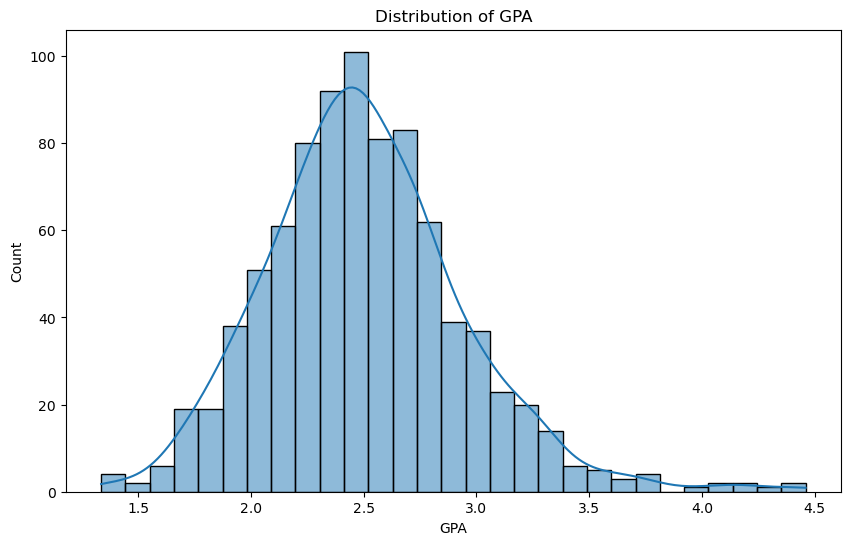

In [6]:
# Check distribution of the target variable (GPA)
plt.figure(figsize=(10, 6))
sns.histplot(df['gpa'], kde=True)
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.show() #vplt.savefig('gpa_distribution.png')
plt.close()

In [7]:
# Analysis of categorical variables in relation to GPA
categorical_cols = ['SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE', 
                    'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY']

In [8]:
# Create a function to plot the relationship between categorical features and GPA
def plot_categorical_vs_gpa(df, col):
    if df[col].notnull().sum() > 0:  # Only plot if there are non-null values
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col, y='gpa', data=df)
        plt.title(f'GPA by {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show() # plt.savefig(f'gpa_by_{col.lower().replace(" ", "_")}.png')
        plt.close()

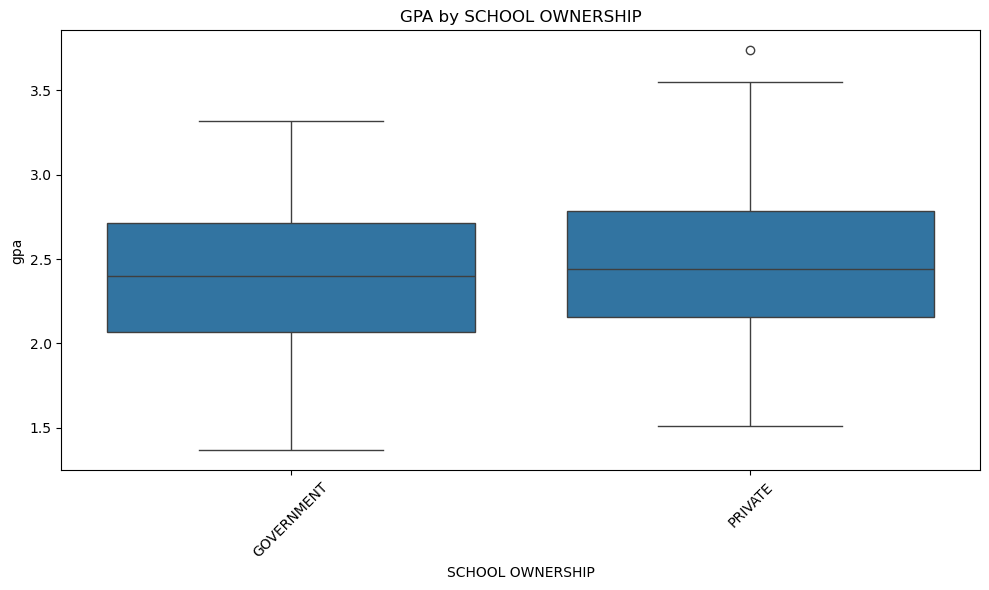

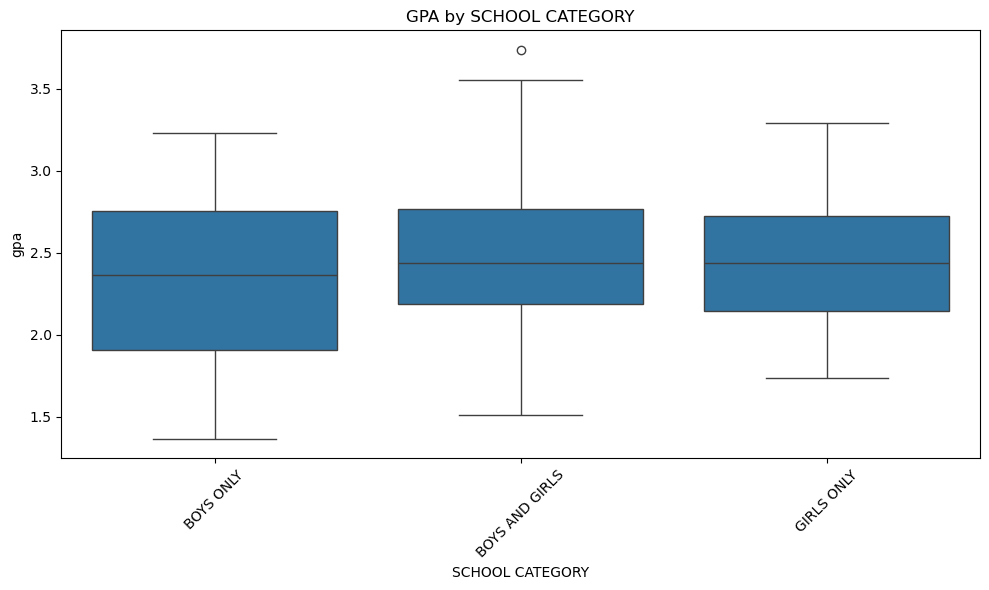

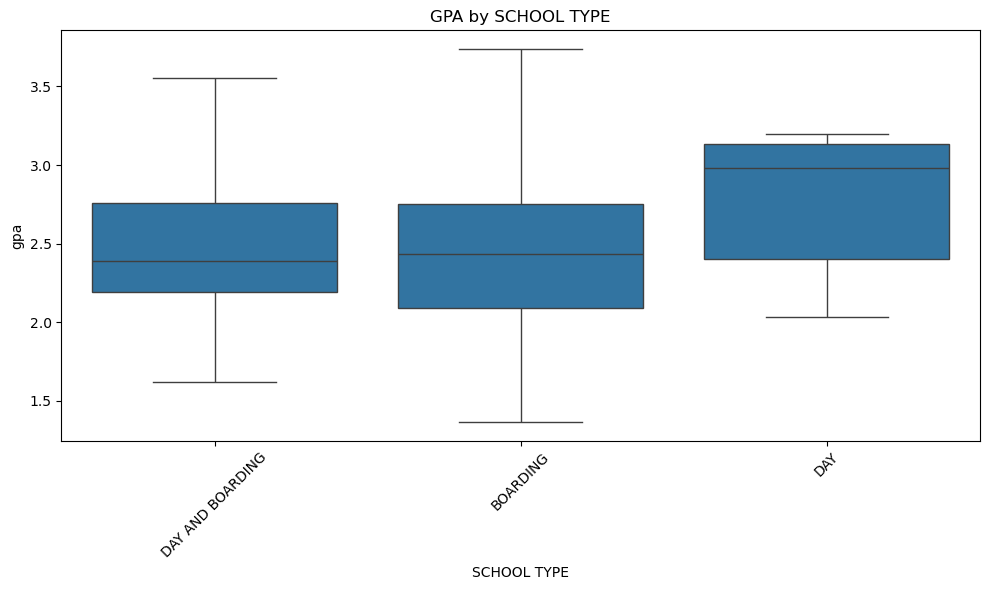

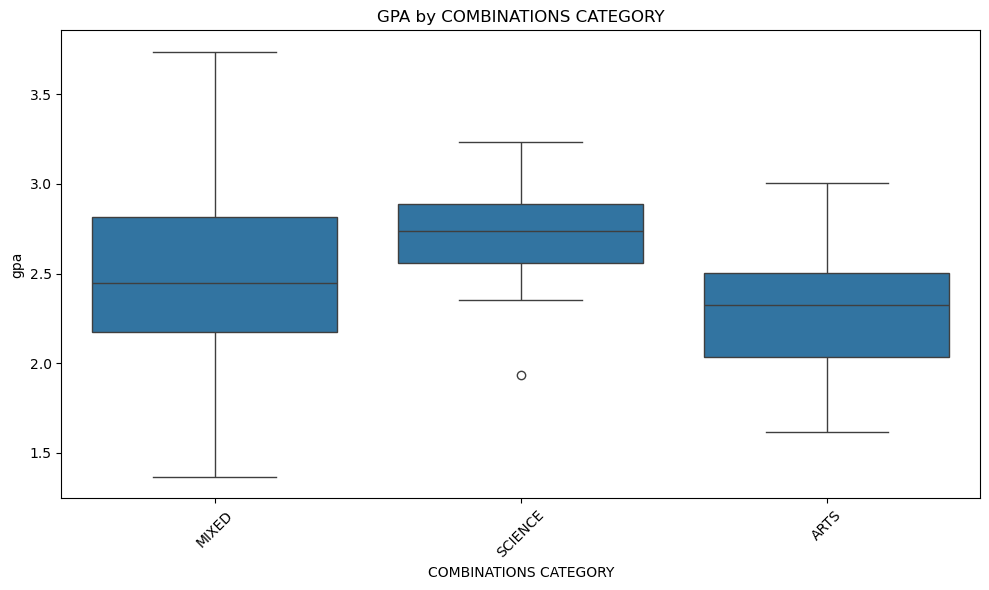

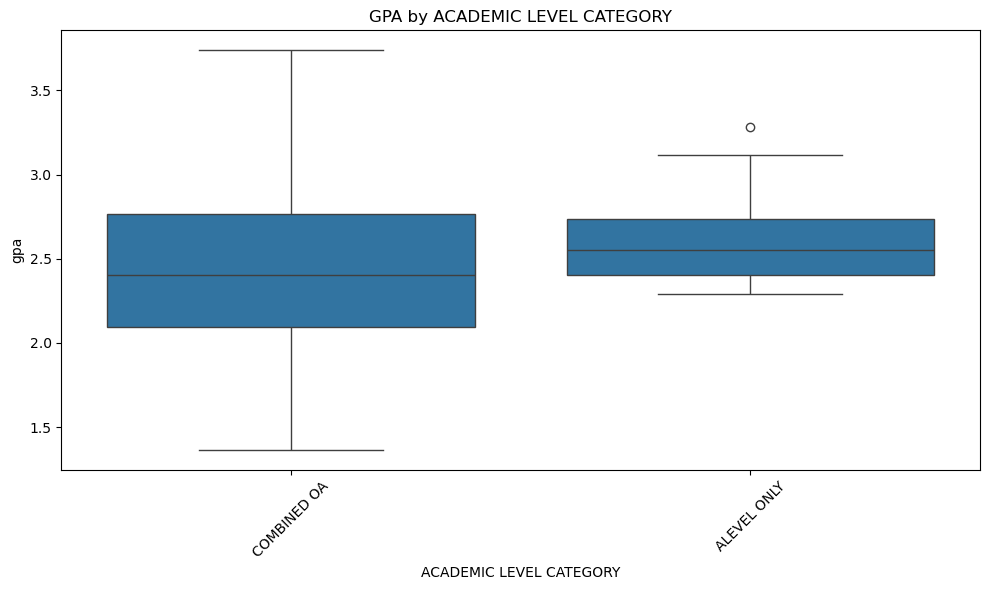

In [9]:
# Plot for each categorical column
for col in categorical_cols:
    plot_categorical_vs_gpa(df, col)

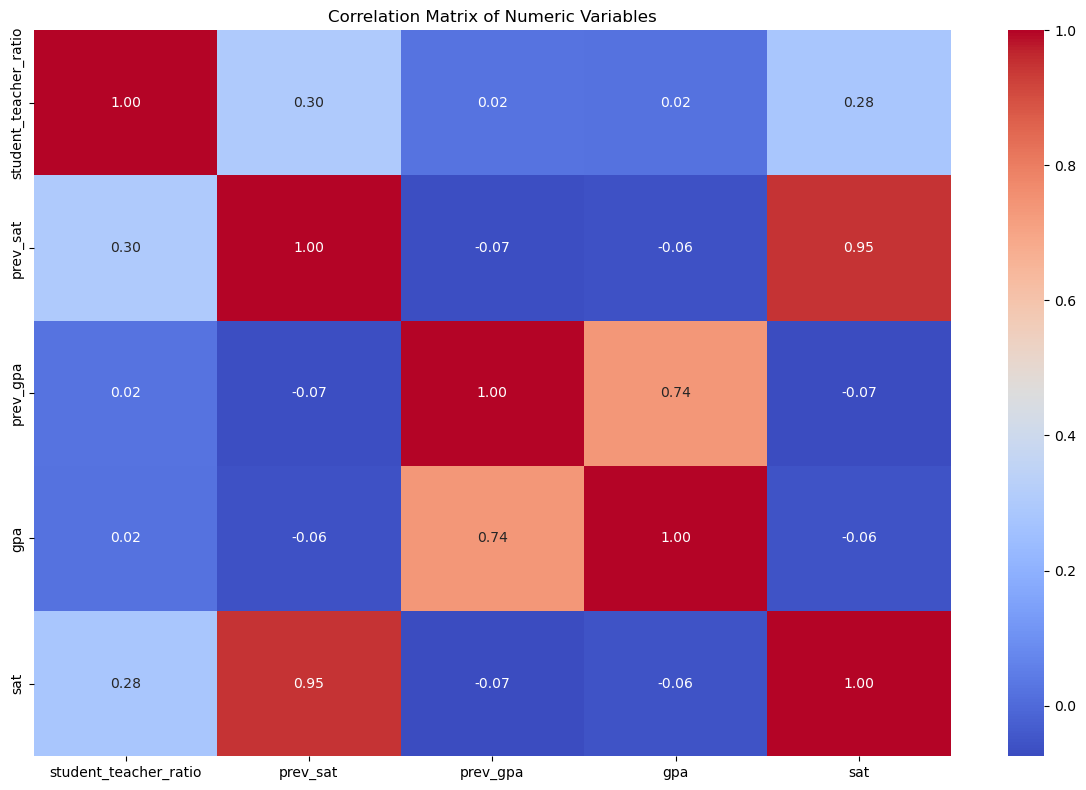

In [10]:
# Correlation matrix for numeric columns
numeric_cols = ['student_teacher_ratio','prev_sat', 'prev_gpa', 'gpa', 'sat']
plt.figure(figsize=(12, 8))
correlation = df[numeric_cols].corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show() # plt.savefig('correlation_matrix.png')
plt.close()

In [11]:
print("\nCorrelation with GPA:")
print(correlation['gpa'].sort_values(ascending=False))


Correlation with GPA:
gpa                      1.000000
prev_gpa                 0.737711
student_teacher_ratio    0.019983
sat                     -0.057691
prev_sat                -0.061553
Name: gpa, dtype: float64


In [12]:
# 2. FEATURE ENGINEERING

# Create interaction terms
df['prev_gpa_sat_interaction'] = df['prev_gpa'] * df['prev_sat']

# Calculate SAT retention rate
df['sat_retention'] = df['sat'] / df['prev_sat']

In [13]:
# 3. FEATURE SELECTION AND PREPROCESSING
# Separate features and target
X = df.drop(['gpa','STUDENTS','TEACHERS'], axis=1)
y = df['gpa']

X_linear = df.dropna(axis=0).drop(['gpa','STUDENTS','TEACHERS'], axis=1)
y_linear = df.dropna(axis=0)['gpa']

# Define feature groups
numeric_features = ['prev_sat', 'prev_gpa', 'sat', 'student_teacher_ratio',
                     'prev_gpa_sat_interaction', 'sat_retention']
categorical_features = ['SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE',
                        'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY']

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer to apply the appropriate preprocessing to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [14]:
# 4. MODEL TRAINING AND EVALUATION
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [15]:
# Function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Create full pipeline with preprocessing
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    if model_name == 'Linear Regression':
        X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)
    # Train the model
    full_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = full_pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(full_pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Print results
    print(f"\nModel: {model_name}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Cross-validation RMSE: {cv_rmse:.4f}")

    # Save the model
    os.makedirs('models', exist_ok=True)
    model_path = os.path.join('models', f'{model_name.replace(" ", "_").lower()}_pipeline.pkl')
    joblib.dump(full_pipeline, model_path)
    print(f"Model saved to: {model_path}")
    
    return {
        'model_name': model_name,
        'pipeline': full_pipeline,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'cv_rmse': cv_rmse
    }

In [16]:
# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)


Model: Linear Regression
Test RMSE: 0.2750
Test MAE: 0.1939
Test R²: 0.6739
Cross-validation RMSE: 0.2990
Model saved to: models/linear_regression_pipeline.pkl

Model: Random Forest
Test RMSE: 0.3244
Test MAE: 0.2418
Test R²: 0.4323
Cross-validation RMSE: 0.3200
Model saved to: models/random_forest_pipeline.pkl

Model: Gradient Boosting
Test RMSE: 0.3226
Test MAE: 0.2378
Test R²: 0.4387
Cross-validation RMSE: 0.3149
Model saved to: models/gradient_boosting_pipeline.pkl


In [17]:
# Find the best model based on RMSE
best_model = min(results, key=lambda x: x['rmse'])
print(f"\nBest model: {best_model['model_name']} with RMSE: {best_model['rmse']:.4f}")

# 5. FEATURE IMPORTANCE ANALYSIS (for the best model)
if best_model['model_name'] in ['Random Forest', 'Gradient Boosting']:
    # Get feature names after preprocessing
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numeric_features) + list(cat_features)
    
    # Extract the model from the pipeline
    model_instance = best_model['pipeline'].named_steps['model']
    
    # Get feature importances
    feature_importances = model_instance.feature_importances_
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance ({best_model["model_name"]})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("\nTop 10 Most Important Features:")
    for i in range(min(10, len(sorted_idx))):
        print(f"{feature_names[sorted_idx[i]]}: {feature_importances[sorted_idx[i]]:.4f}")


Best model: Linear Regression with RMSE: 0.2750


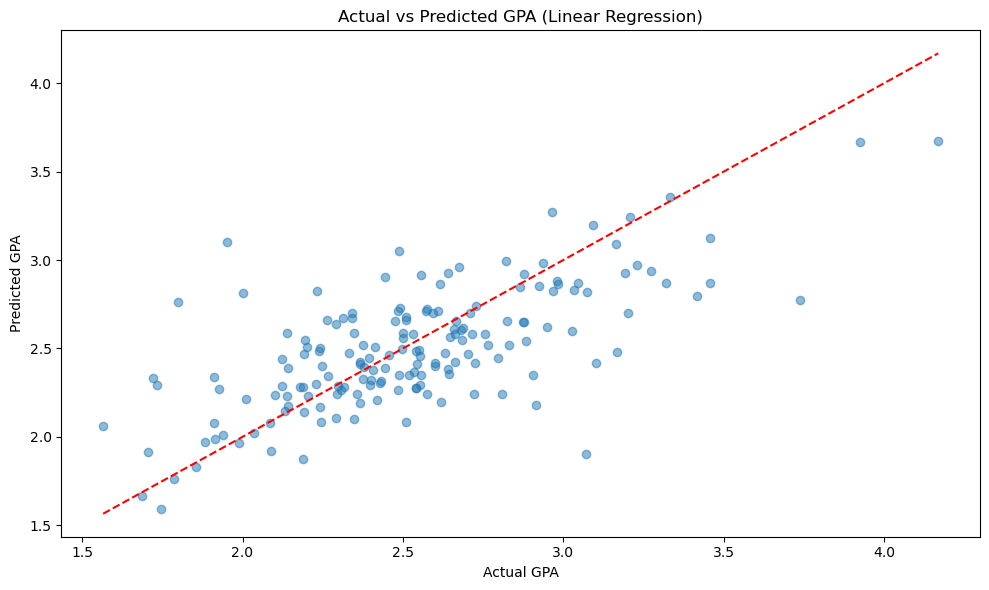

In [18]:
# 6. MODEL INTERPRETATION
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
y_pred = best_model['pipeline'].predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title(f'Actual vs Predicted GPA ({best_model["model_name"]})')
plt.tight_layout()
plt.show() # plt.savefig('actual_vs_predicted.png')
plt.close()

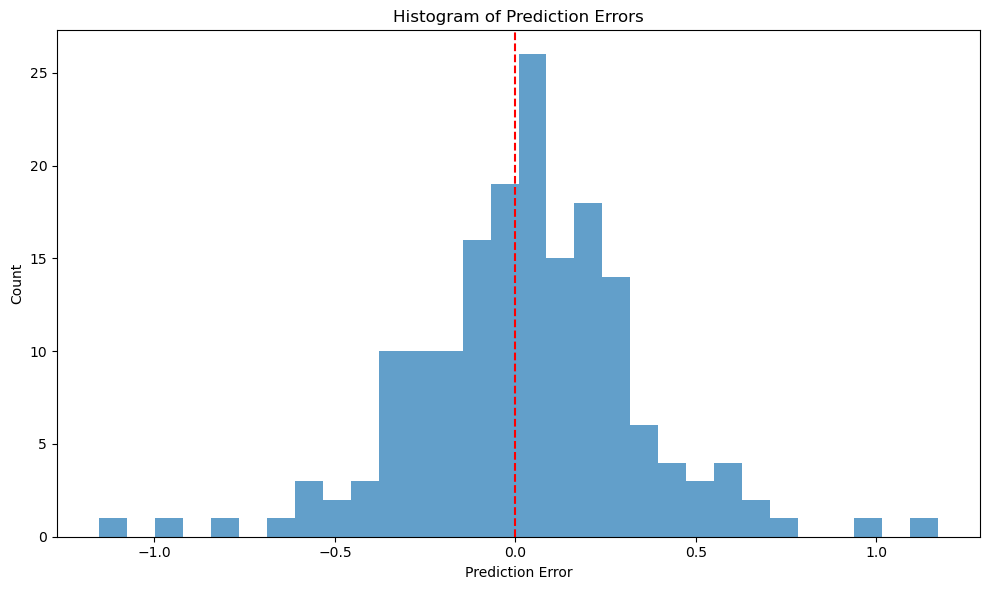

In [19]:
# Plot prediction errors
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Histogram of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show() # plt.savefig('prediction_errors.png')
plt.close()